# Spainish A/B test

## Import Package

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
import graphviz

## Load Data

In [18]:
test_table = pd.read_csv('test_table.csv')
user_table = pd.read_csv('user_table.csv')
test_origin = test_table.copy()
user_origin = user_table.copy()

In [19]:
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [7]:
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [64]:
print('There are %i users, and %i features in test table.' % (test_table.shape[0], test_table.shape[1]))
print('There are %i users, and %i features in user table. ' % (user_table.shape[0], user_table.shape[1]))
print('There are', len(test_table[~test_table["user_id"].isin(user_table["user_id"])]), \
    'users in test table but have no user information. They are potential new users, but due to insufficient user information, we exclude them from the test table.')

There are 453321 users, and 9 features in test table.
There are 452867 users, and 4 features in user table. 
There are 454 users in test table but have no user information. They are potential new users, but due to insufficient user information, we exclude them from the test table.


In [65]:
test_table = test_table[test_table['user_id'].isin(user_table['user_id'])]

## Exploratory Data Analysis

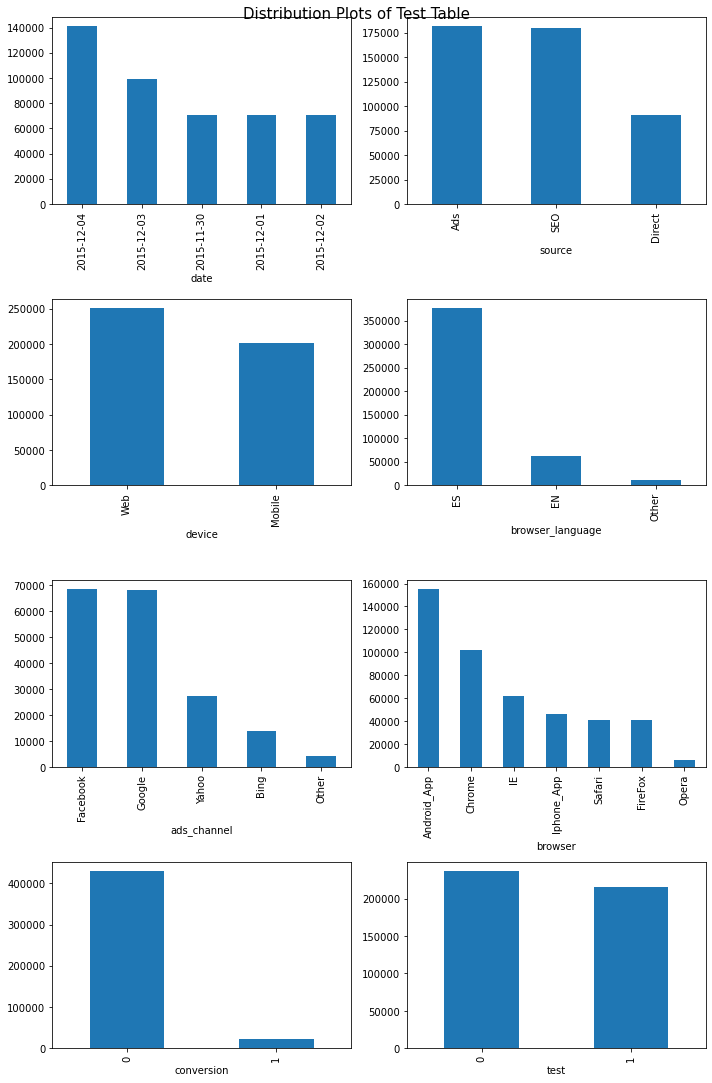

In [81]:
### test table:
plt.subplots(figsize = (10, 15))
i = 1
for col in test_table.columns[1:]:
    plt.subplot(4, 2, i)
    test_table[col].value_counts().plot(kind = 'bar')
    plt.xlabel(col)
    plt.tight_layout() 
    i += 1
plt.suptitle('Distribution Plots of Test Table',fontsize=15,y=1)
plt.show()


### Note: 
1. Dates range only 5 days in the begining of December, right after Thanksgiving. The lower conversion rate might caused by regular cycle.
2. Much less "Direct" source.
3. Some of the customers have browser language other than Spain. 

In [79]:
test_total_user = len(test_table)
conversion_rate = sum(test_table['conversion'] == 1) / test_total_user
test_user = sum(test_table['test'] == 1)

print('The conversion rate of this test is %.2f. \nFor total %i users in the test table, %.2f%% of them are in the test group.' \
     % (conversion_rate,  test_total_user, test_user/test_total_user * 100))

The conversion rate of this test is 0.05. 
For total 452867 users in the test table, 47.65% of them are in the test group


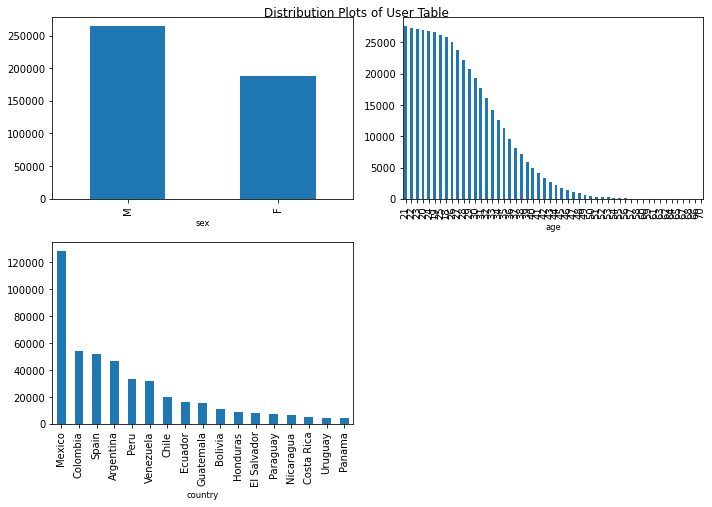

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa3e77285e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa3e7728ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa3e7728280>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa3e78ae3a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa3e78ae6a0>],
 'means': []}

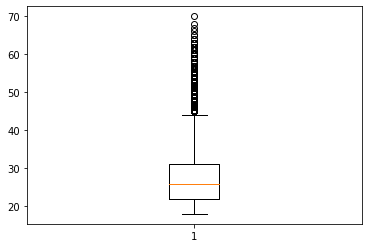

In [100]:
### user table:

plt.subplots(figsize = (10, 7))
i = 1
for col in user_table.columns[1:]:
    plt.subplot(2, 2, i)
    user_table[col].value_counts().plot(kind = 'bar')
    plt.xlabel(col, fontsize = 'smaller')
    plt.tight_layout() 
    i += 1
plt.suptitle('Distribution Plots of User Table',fontsize=12,y=1)
plt.show()

plt.boxplot(user_table['age'])

### Note: 
1. More male user than femal user.
2. Age spread from 21 to 70. Most customers are young adults in 20s.
3. Most users are from Mexico, spaniard are the third largest group. 

## Join the tables

In [164]:
joined_table = pd.merge(test_table, user_table, how='inner')
joined_table['country'] = [1 if x == 'Spain' else 0 for x in joined_table['country']]
joined_table['sex'] = [1 if x == 'M' else 0 for x in joined_table['sex']]
spain_user = joined_table[joined_table['country'] == 1]
non_spain_user = joined_table[joined_table['country'] == 0]
non_spain_user_test = non_spain_user[non_spain_user['test'] == 1]
non_spain_user_control = non_spain_user[non_spain_user['test'] == 0]

In [165]:
total_conv_rate = sum(joined_table['conversion'] == 1) / len(joined_table)
spain_conv_rate = sum(spain_user['conversion'] == 1) / len(spain_user)
non_spain_conv_rate_control = sum(non_spain_user_control['conversion'] == 1) / len(non_spain_user_control)
non_spain_conv_rate_test = sum(non_spain_user_test['conversion'] == 1) / len(non_spain_user_test)

print('The total conversion rate is {:.2f}%.'.format(100*total_conv_rate), \
      '\nThe Spaniard take up {:.2f}% of the control group. \
      Their conversion rate is {:.2f}%.'.format(len(spain_user)/sum(joined_table['test'] == 0)*100, 100*spain_conv_rate), \
     '\nThe conversion rate of non-Spaniard in the control group is {:.2f}%.'.format(100*non_spain_conv_rate_control), \
     '\nThe conversion rate of non-Spaniard in the test group is {:.2f}%.'.format(100*non_spain_conv_rate_test))


The total conversion rate is 4.96%. 
The Spaniard take up 21.84% of the control group.       Their conversion rate is 7.97%. 
The conversion rate of non-Spaniard in the control group is 4.83%. 
The conversion rate of non-Spaniard in the test group is 4.34%.


### Note:
1. The conversion rate of the Spaniard is much higher than the all other conversion rate.
2. Looks like the conversion rate decreases in the test group.
3. The Spainard should be set as a baseline group, by observing the conversion rate change within this group before and after this test, we can understand the enviornmental change for all users. For example, sesson cycle.

In [166]:
spain_user_converted = spain_user[spain_user['conversion'] == 1]
spain_user_not_converted = spain_user[spain_user['conversion'] == 0]
non_spain_user_test_converted = non_spain_user_test[non_spain_user_test['conversion'] == 1]
non_spain_user_test_not_converted = non_spain_user_test[non_spain_user_test['conversion'] == 0]
non_spain_user_control_converted = non_spain_user_control[non_spain_user_control['conversion'] == 1]
non_spain_user_control_not_converted = non_spain_user_control[non_spain_user_control['conversion'] == 0]
spain_user_converted.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,1,32,1
12,744811,2015-12-01,SEO,Mobile,ES,NaN,Android_App,1,0,0,32,1
96,807531,2015-12-04,SEO,Mobile,ES,NaN,Android_App,1,0,1,22,1
104,681217,2015-12-04,Ads,Mobile,ES,Google,Android_App,1,0,1,22,1
183,251083,2015-12-03,SEO,Mobile,ES,NaN,Android_App,1,0,1,20,1


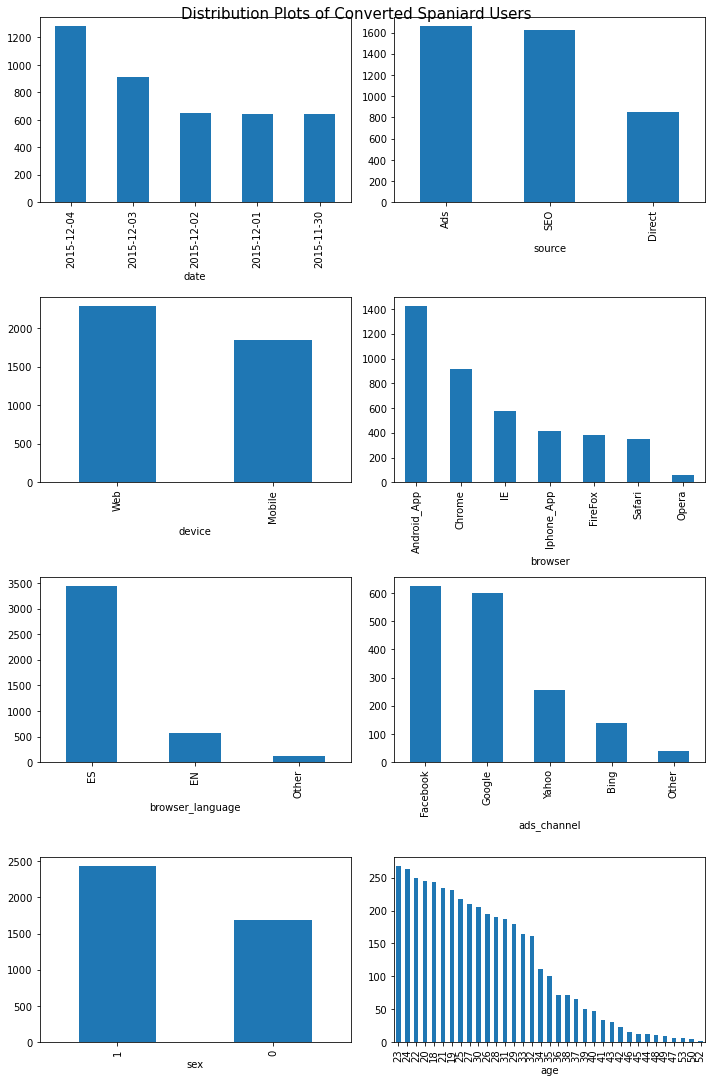

In [194]:
plt.subplots(figsize = (10, 15))
i = 1
for col in ['date', 'source', 'device', 'browser', 'browser_language', 'ads_channel', 'sex', 'age']:
    plt.subplot(4, 2, i)
    spain_user_converted[col].value_counts().plot(kind = 'bar')
    plt.xlabel(col)
    plt.tight_layout() 
    i += 1
plt.suptitle('Distribution Plots of Converted Spaniard Users',fontsize=15,y=1)
plt.show()


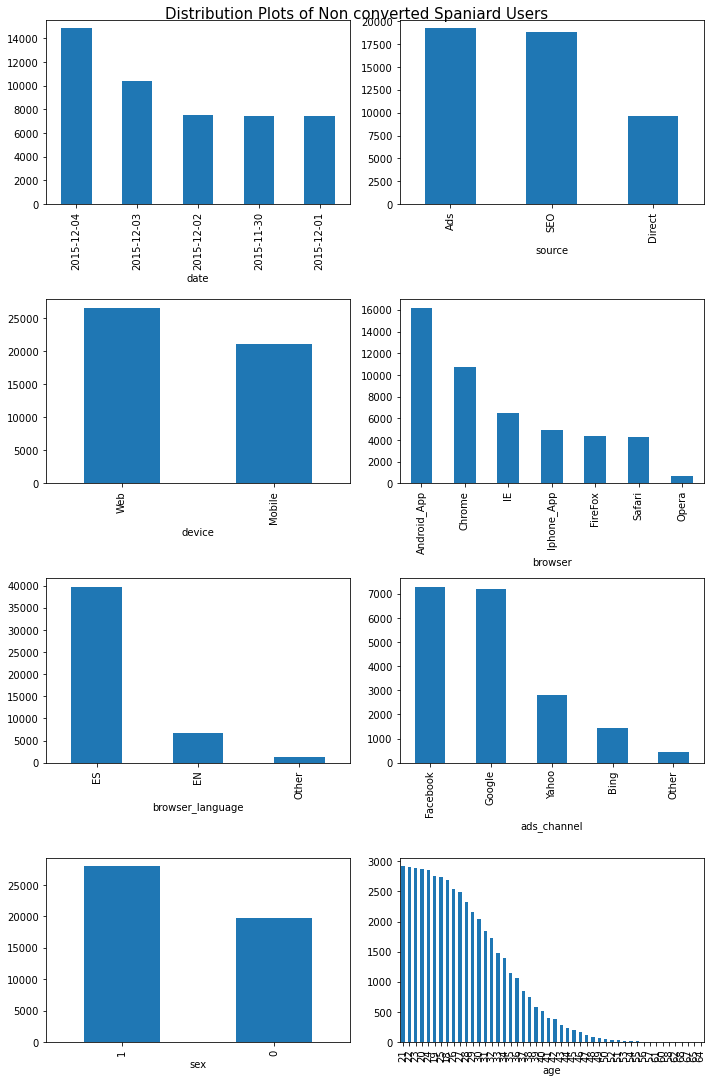

In [195]:
plt.subplots(figsize = (10, 15))
i = 1
for col in ['date', 'source', 'device', 'browser', 'browser_language', 'ads_channel', 'sex', 'age']:
    plt.subplot(4, 2, i)
    spain_user_not_converted[col].value_counts().plot(kind = 'bar')
    plt.xlabel(col)
    plt.tight_layout() 
    i += 1
plt.suptitle('Distribution Plots of Non converted Spaniard Users',fontsize=15,y=1)
plt.show()


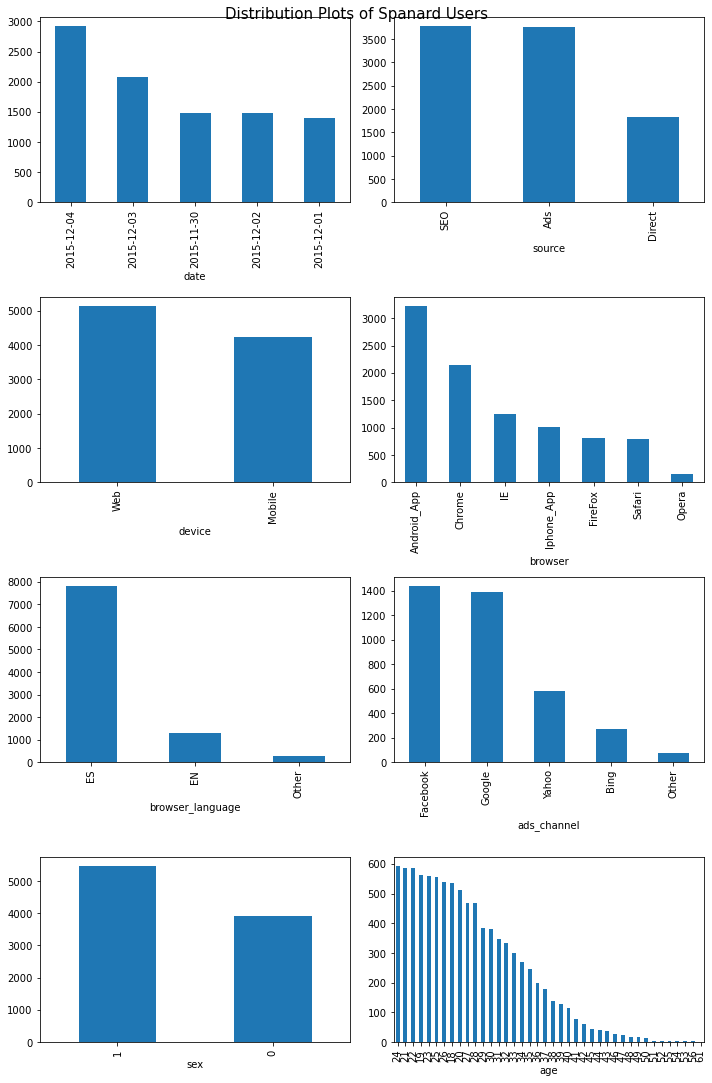

In [182]:
plt.subplots(figsize = (10, 15))
i = 1
for col in ['date', 'source', 'device', 'browser', 'browser_language', 'ads_channel', 'sex', 'age']:
    plt.subplot(4, 2, i)
    non_spain_user_test_converted[col].value_counts().plot(kind = 'bar')
    plt.xlabel(col)
    plt.tight_layout() 
    i += 1
plt.suptitle('Distribution Plots of Converted Non Spaniard Users',fontsize=15,y=1)
plt.show()


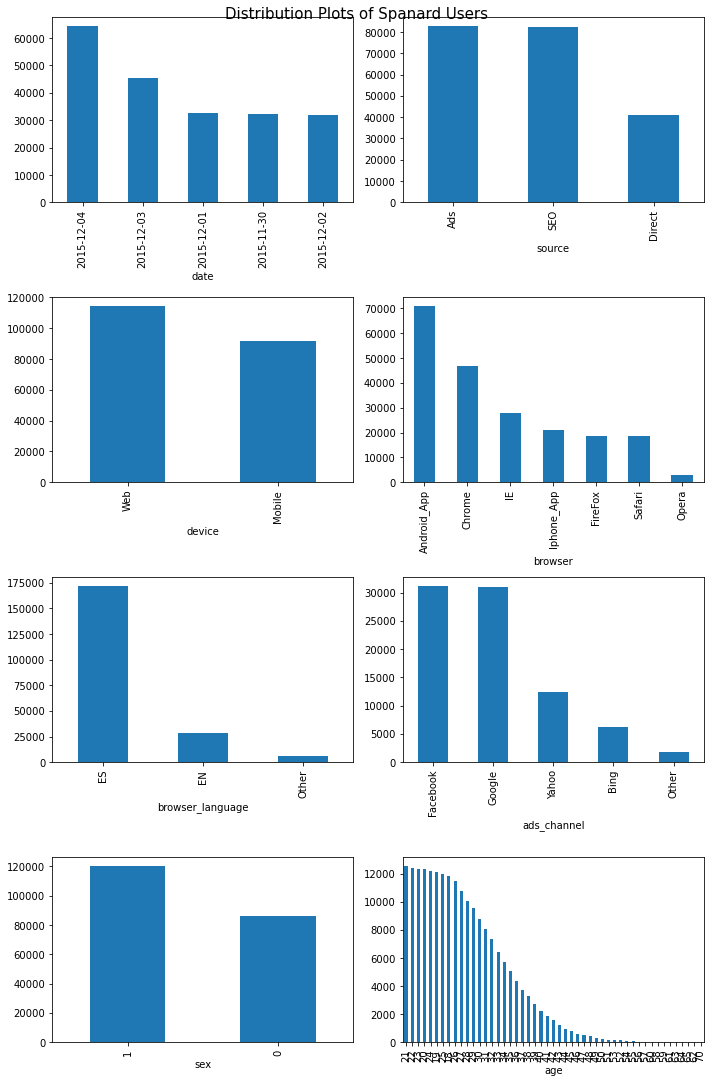

In [183]:
plt.subplots(figsize = (10, 15))
i = 1
for col in ['date', 'source', 'device', 'browser', 'browser_language', 'ads_channel', 'sex', 'age']:
    plt.subplot(4, 2, i)
    non_spain_user_test_not_converted[col].value_counts().plot(kind = 'bar')
    plt.xlabel(col)
    plt.tight_layout() 
    i += 1
plt.suptitle('Distribution Plots of Non converted Non Spaniard Users',fontsize=15,y=1)
plt.show()


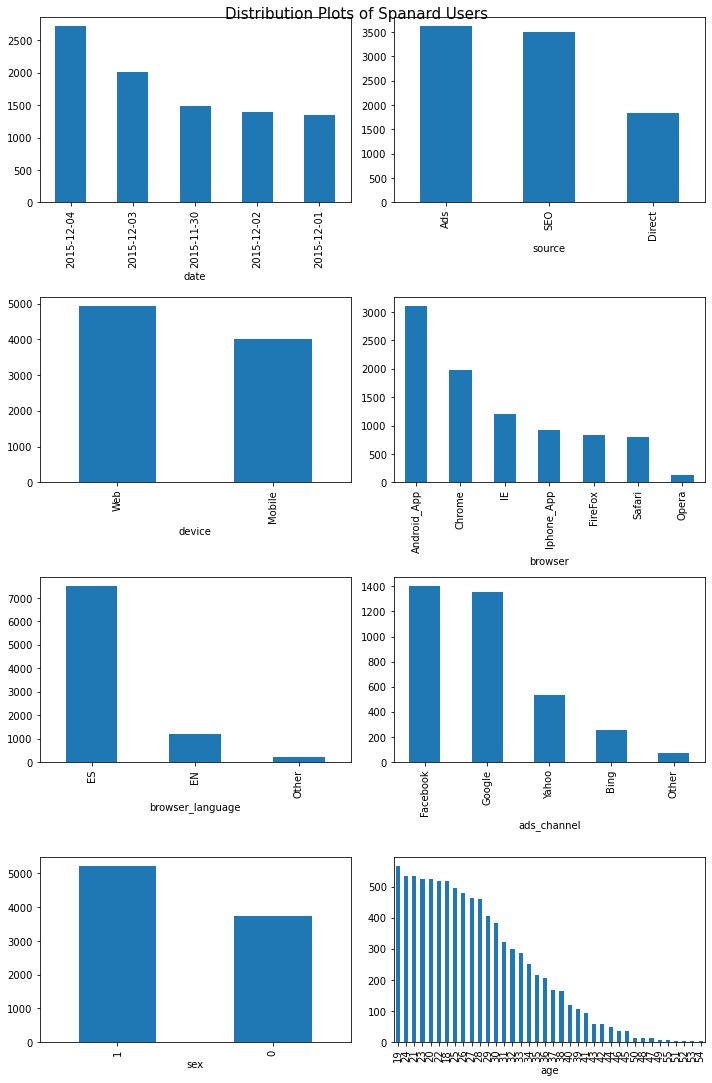

In [184]:
plt.subplots(figsize = (10, 15))
i = 1
for col in ['date', 'source', 'device', 'browser', 'browser_language', 'ads_channel', 'sex', 'age']:
    plt.subplot(4, 2, i)
    non_spain_user_control_converted[col].value_counts().plot(kind = 'bar')
    plt.xlabel(col)
    plt.tight_layout() 
    i += 1
plt.suptitle('Distribution Plots of Spanard Users',fontsize=15,y=1)
plt.show()

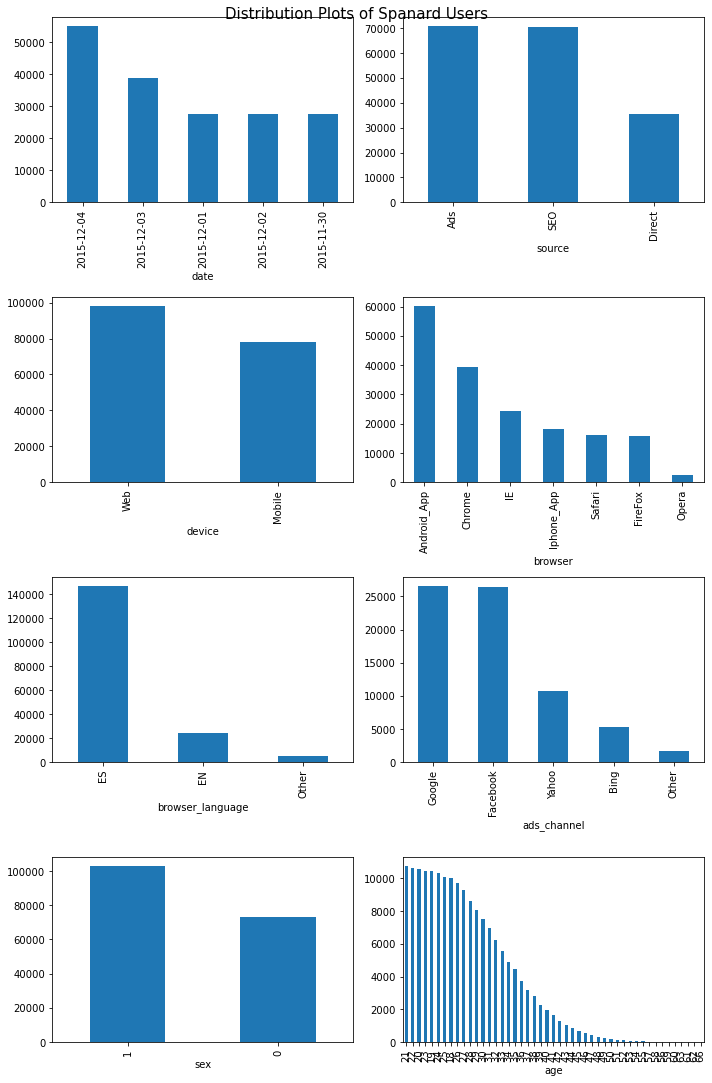

In [185]:
plt.subplots(figsize = (10, 15))
i = 1
for col in ['date', 'source', 'device', 'browser', 'browser_language', 'ads_channel', 'sex', 'age']:
    plt.subplot(4, 2, i)
    non_spain_user_control_not_converted[col].value_counts().plot(kind = 'bar')
    plt.xlabel(col)
    plt.tight_layout() 
    i += 1
plt.suptitle('Distribution Plots of Spanard Users',fontsize=15,y=1)
plt.show()


Text(0.5, 1, 'Source by Country')

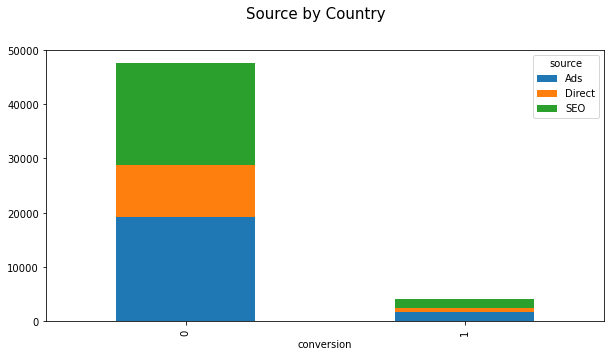

In [187]:
pivot_df = spain_user[['conversion', 'source']].pivot_table(index='conversion', columns='source', aggfunc=len, fill_value=0)
pivot_df.loc[[0,1],:].plot.bar(stacked=True, figsize=(10,5))
plt.suptitle('Source by Spaniard Conversion',fontsize=15,y=1)

In [188]:
pivot_df["sum"] = pivot_df.iloc[:,0] + pivot_df.iloc[:,1] + pivot_df.iloc[:,2]
pivot_df_new = pivot_df.iloc[:,0:3].div(pivot_df["sum"], axis=0)
pivot_df_new

source,Ads,Direct,SEO
conversion,,,
0,0.403597,0.201578,0.394825
1,0.402132,0.205184,0.392684


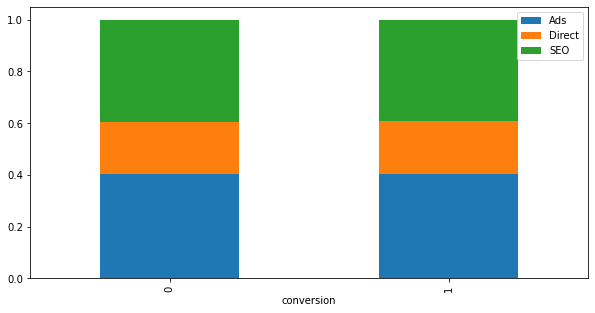

In [191]:
pivot_df_new.loc[[0,1],:].plot.bar(stacked=True, figsize=(10,5))
plt.legend(loc='upper right')

### Note: 
1. The conversion rate decreased for thr test group.
2. There is no comparable baseline control group. 
3. Reasons of this decrease could be seasonal cycle, content difference.